In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.style as style


In [2]:
import torchvision
import numpy as np

# Define transformation
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize(
                mean=[0.49139968, 0.48215827, 0.44653124],
                std=[0.24703233, 0.24348505, 0.26158768],
            )])

import torch.utils.data as data

# Define the transform to apply to the data
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


# Load the CIFAR-10 training and test datasets separately
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Combine the training and test datasets into a single dataset
dataset = torch.utils.data.ConcatDataset([trainset, testset])


# Print the shapes of the loaded data
print('Combined Images:', len(dataset))
print('Combined Labels:', len(trainset.targets) + len(testset.targets))
dataset.targets = trainset.targets + testset.targets

100%|██████████| 170498071/170498071 [00:03<00:00, 48253686.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Combined Images: 60000
Combined Labels: 60000


In [3]:
np.random.seed(42)
train_indices = []
val_indices = []
test_indices = np.arange(len(dataset))

train_size = 54000
val_size = 6000

for i in range(10):
    if i == 6:  # Exclude frog class (class index 6)
        continue

    class_indices = np.where(np.array(dataset.targets) == i)[0]
    np.random.shuffle(class_indices)
    train_indices.extend(class_indices[:5400])
    val_indices.extend(class_indices[5400:6000])

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

# Update dataset and labels
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_labels = np.array(dataset.targets)[train_indices]
val_labels = np.array(dataset.targets)[val_indices]

# Adjust labels to be 0 to 9
train_labels[train_labels > 6] -= 1
val_labels[val_labels > 6] -= 1

# Print label distribution
print(f"Training label distribution: {np.bincount(train_labels)}")
print(f"Validation label distribution: {np.bincount(val_labels)}")

Training label distribution: [5400 5400 5400 5400 5400 5400 5400 5400 5400]
Validation label distribution: [600 600 600 600 600 600 600 600 600]


In [4]:
batch_size = 256

import torch
from torchvision import datasets, transforms

class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, filter_label):
        self.dataset = dataset
        self.filter_label = filter_label
        self.filtered_indices = self._filter_indices()

    def __getitem__(self, index):
        return self.dataset[self.filtered_indices[index]]

    def __len__(self):
        return len(self.filtered_indices)

    def _filter_indices(self):
        filtered_indices = []
        for i, (_, label) in enumerate(self.dataset):
            if label != self.filter_label:
                filtered_indices.append(i)
        return filtered_indices


# Load the CIFAR-10 train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create filtered trainset and testset without label 6
trainset_filtered = FilteredDataset(trainset, filter_label=6)
testset_filtered = FilteredDataset(testset, filter_label=6)

# Create data loaders for filtered trainset and testset
batch_size = 256
train_loader = torch.utils.data.DataLoader(trainset_filtered, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset_filtered, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
unique_labels = set()

for batch in train_loader:
    _, labels = batch  # Assuming each batch consists of (data, labels) tuples
    unique_labels.update(labels.tolist())

print("Unique labels in train_loader:", unique_labels)

Unique labels in train_loader: {0, 1, 2, 3, 4, 5, 7, 8, 9}


Trainset Label distribution:
7: 5000 (11.11%)
5: 5000 (11.11%)
1: 5000 (11.11%)
8: 5000 (11.11%)
3: 5000 (11.11%)
0: 5000 (11.11%)
2: 5000 (11.11%)
9: 5000 (11.11%)
4: 5000 (11.11%)


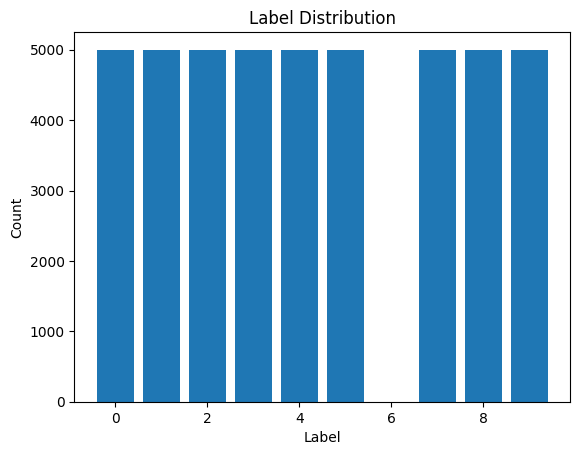

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

labels = []
for batch in train_loader:
    _, label = batch
    labels.extend(label.tolist())

label_counts = Counter(labels)
total_count = sum(label_counts.values())

print("Trainset Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count/total_count:.2%})")

plt.bar(label_counts.keys(), label_counts.values())
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Label distribution:
3: 1000 (11.11%)
8: 1000 (11.11%)
0: 1000 (11.11%)
1: 1000 (11.11%)
9: 1000 (11.11%)
5: 1000 (11.11%)
7: 1000 (11.11%)
4: 1000 (11.11%)
2: 1000 (11.11%)


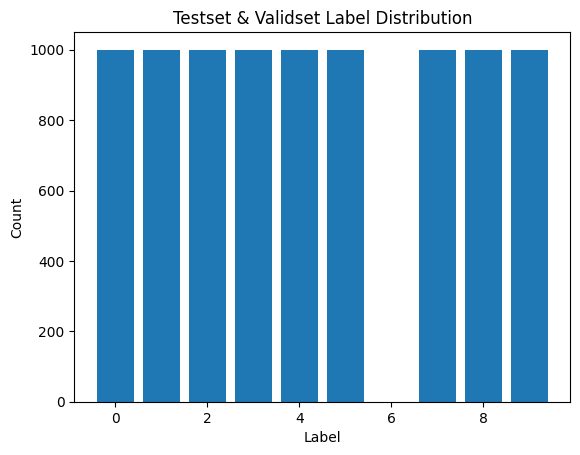

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

labels = []
for batch in test_loader:
    _, label = batch
    labels.extend(label.tolist())

label_counts = Counter(labels)
total_count = sum(label_counts.values())

print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count/total_count:.2%})")

plt.bar(label_counts.keys(), label_counts.values())
plt.title('Testset & Validset Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [19]:
import torch
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

# Load the ResNet18 model
#model = models.resnet18(pretrained=False)
#model.fc = torch.nn.Linear(in_features=512, out_features=10)
#num_epochs = 120
#lr = 0.1


import torch
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

# Load the ResNet18 model
#model = models.resnet18(pretrained=False)
#model.fc = torch.nn.Linear(in_features=512, out_features=10)
#num_epochs = 120
#lr = 0.1


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch
import torch.nn as nn
import torch.nn.functional as F
class ResNet18(nn.Module):
    def __init__(
        self, in_channels=3, num_classes=9, pretrained=None, embedding_reduction=False
    ):
        super(ResNet18, self).__init__()

        self.resnet18 = torchvision.models.resnet18(weights=pretrained)
        self.resnet18.conv1 = nn.Conv2d(
            in_channels,
            64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False,
        )
        self.resnet18.fc = nn.Linear(
            in_features=512, out_features=num_classes, bias=True
        )
        self.backbone = nn.Sequential(*list(self.resnet18.children())[:-1])
        self.classifier = nn.Sequential(self.resnet18.fc)

        self.embedding_reduction = embedding_reduction

        self.fc_embeding_reduction = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
        )

    def forward(self, x, embedding=False):
        x = self.backbone(x)
        x = torch.flatten(x, start_dim=1)
        if embedding and self.embedding_reduction:
            x = self.fc_embeding_reduction(x)
            x = torch.nn.functional.normalize(x)
        if not embedding:
            x = self.classifier(x)
        return x

    def fix_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False


# Step 1: Define a model
model = ResNet18(in_channels= 3, pretrained= True).to(device)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)


def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 256
num_epochs = 200
lr = 0.1

# Step 1: Define a model
#my_model = ResNet(BasicBlock, [2,2,2,2], num_classes=10) #ResNet18
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#my_model.to(device)
#model.to(device)

In [20]:
# Step 2: Define a loss function and training algorithm
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)


class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, filter_label):
        self.dataset = dataset
        self.filter_label = filter_label
        self.filtered_indices = self._filter_indices()

    def __getitem__(self, index):
        orig_index, label = self.filtered_indices[index]
        image, _ = self.dataset[orig_index]
        return image, label

    def __len__(self):
        return len(self.filtered_indices)

    def _filter_indices(self):
        filtered_indices = []
        label_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: 6, 8: 7, 9: 8}
        for i, (image, label) in enumerate(self.dataset):
            if label in label_mapping:
                filtered_indices.append((i, label_mapping[label]))
        return filtered_indices


# Load the CIFAR-10 train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create filtered trainset and testset without label 6
trainset_filtered = FilteredDataset(trainset, filter_label=6)
testset_filtered = FilteredDataset(testset, filter_label=6)

# Create data loaders for filtered trainset and testset
batch_size = 256
train_loader = torch.utils.data.DataLoader(trainset_filtered, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset_filtered, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



Files already downloaded and verified
Files already downloaded and verified


In [21]:

unique_labels = set()
for _, label in trainset_filtered:
    unique_labels.add(label)

print("Unique labels in trainset_filtered:", unique_labels)

Unique labels in trainset_filtered: {0, 1, 2, 3, 4, 5, 6, 7, 8}


Epoch 1: 100%|██████████| 36/36 [00:02<00:00, 13.35batch/s, accuracy=0.254, loss=2.22]


Epoch: 1, learning rate: 0.01, Training Loss: 2.2134, Training Accuracy: 0.2062, Test Loss: 2.2211, Test Accuracy: 0.2543


Epoch 2: 100%|██████████| 36/36 [00:03<00:00, 10.24batch/s, accuracy=0.37, loss=1.62]


Epoch: 2, learning rate: 0.01, Training Loss: 1.7570, Training Accuracy: 0.3312, Test Loss: 1.6168, Test Accuracy: 0.3702


Epoch 3: 100%|██████████| 36/36 [00:03<00:00, 10.44batch/s, accuracy=0.421, loss=1.51]


Epoch: 3, learning rate: 0.01, Training Loss: 1.6282, Training Accuracy: 0.3798, Test Loss: 1.5143, Test Accuracy: 0.4212


Epoch 4: 100%|██████████| 36/36 [00:02<00:00, 12.94batch/s, accuracy=0.452, loss=1.45]


Epoch: 4, learning rate: 0.01, Training Loss: 1.4740, Training Accuracy: 0.4350, Test Loss: 1.4506, Test Accuracy: 0.4520


Epoch 5: 100%|██████████| 36/36 [00:02<00:00, 13.99batch/s, accuracy=0.492, loss=1.41]


Epoch: 5, learning rate: 0.01, Training Loss: 1.3416, Training Accuracy: 0.4910, Test Loss: 1.4150, Test Accuracy: 0.4918


Epoch 6: 100%|██████████| 36/36 [00:02<00:00, 13.13batch/s, accuracy=0.578, loss=1.17]


Epoch: 6, learning rate: 0.01, Training Loss: 1.2263, Training Accuracy: 0.5425, Test Loss: 1.1683, Test Accuracy: 0.5777


Epoch 7: 100%|██████████| 36/36 [00:02<00:00, 13.72batch/s, accuracy=0.605, loss=1.09]


Epoch: 7, learning rate: 0.01, Training Loss: 1.1260, Training Accuracy: 0.5800, Test Loss: 1.0893, Test Accuracy: 0.6047


Epoch 8: 100%|██████████| 36/36 [00:03<00:00, 11.87batch/s, accuracy=0.603, loss=1.1]


Epoch: 8, learning rate: 0.01, Training Loss: 1.0439, Training Accuracy: 0.6168, Test Loss: 1.0990, Test Accuracy: 0.6027


Epoch 9: 100%|██████████| 36/36 [00:03<00:00,  9.79batch/s, accuracy=0.629, loss=1.03]


Epoch: 9, learning rate: 0.01, Training Loss: 0.9621, Training Accuracy: 0.6480, Test Loss: 1.0309, Test Accuracy: 0.6291


Epoch 10: 100%|██████████| 36/36 [00:02<00:00, 12.97batch/s, accuracy=0.664, loss=0.99]


Epoch: 10, learning rate: 0.01, Training Loss: 0.9113, Training Accuracy: 0.6691, Test Loss: 0.9901, Test Accuracy: 0.6639


Epoch 11: 100%|██████████| 36/36 [00:02<00:00, 13.36batch/s, accuracy=0.648, loss=0.984]


Epoch: 11, learning rate: 0.01, Training Loss: 0.8695, Training Accuracy: 0.6863, Test Loss: 0.9837, Test Accuracy: 0.6484


Epoch 12: 100%|██████████| 36/36 [00:02<00:00, 13.58batch/s, accuracy=0.696, loss=0.854]


Epoch: 12, learning rate: 0.01, Training Loss: 0.8268, Training Accuracy: 0.7009, Test Loss: 0.8542, Test Accuracy: 0.6958


Epoch 13: 100%|██████████| 36/36 [00:02<00:00, 13.33batch/s, accuracy=0.683, loss=0.893]


Epoch: 13, learning rate: 0.01, Training Loss: 0.8040, Training Accuracy: 0.7112, Test Loss: 0.8927, Test Accuracy: 0.6832


Epoch 14: 100%|██████████| 36/36 [00:02<00:00, 12.31batch/s, accuracy=0.724, loss=0.788]


Epoch: 14, learning rate: 0.01, Training Loss: 0.7626, Training Accuracy: 0.7278, Test Loss: 0.7877, Test Accuracy: 0.7240


Epoch 15: 100%|██████████| 36/36 [00:03<00:00,  9.99batch/s, accuracy=0.672, loss=0.957]


Epoch: 15, learning rate: 0.01, Training Loss: 0.7412, Training Accuracy: 0.7341, Test Loss: 0.9571, Test Accuracy: 0.6721


Epoch 16: 100%|██████████| 36/36 [00:03<00:00, 11.30batch/s, accuracy=0.727, loss=0.779]


Epoch: 16, learning rate: 0.01, Training Loss: 0.7141, Training Accuracy: 0.7439, Test Loss: 0.7790, Test Accuracy: 0.7273


Epoch 17: 100%|██████████| 36/36 [00:02<00:00, 13.24batch/s, accuracy=0.726, loss=0.76]


Epoch: 17, learning rate: 0.01, Training Loss: 0.6980, Training Accuracy: 0.7513, Test Loss: 0.7596, Test Accuracy: 0.7258


Epoch 18: 100%|██████████| 36/36 [00:02<00:00, 13.11batch/s, accuracy=0.742, loss=0.745]


Epoch: 18, learning rate: 0.01, Training Loss: 0.6727, Training Accuracy: 0.7595, Test Loss: 0.7451, Test Accuracy: 0.7416


Epoch 19: 100%|██████████| 36/36 [00:02<00:00, 13.80batch/s, accuracy=0.756, loss=0.716]


Epoch: 19, learning rate: 0.01, Training Loss: 0.6487, Training Accuracy: 0.7669, Test Loss: 0.7155, Test Accuracy: 0.7562


Epoch 20: 100%|██████████| 36/36 [00:02<00:00, 13.37batch/s, accuracy=0.743, loss=0.724]


Epoch: 20, learning rate: 0.001, Training Loss: 0.6325, Training Accuracy: 0.7737, Test Loss: 0.7245, Test Accuracy: 0.7434


Epoch 21: 100%|██████████| 36/36 [00:02<00:00, 12.90batch/s, accuracy=0.794, loss=0.591]


Epoch: 21, learning rate: 0.001, Training Loss: 0.5479, Training Accuracy: 0.8052, Test Loss: 0.5908, Test Accuracy: 0.7939


Epoch 22: 100%|██████████| 36/36 [00:03<00:00, 10.13batch/s, accuracy=0.8, loss=0.581]


Epoch: 22, learning rate: 0.001, Training Loss: 0.5211, Training Accuracy: 0.8142, Test Loss: 0.5815, Test Accuracy: 0.7999


Epoch 23: 100%|██████████| 36/36 [00:03<00:00,  9.50batch/s, accuracy=0.803, loss=0.575]


Epoch: 23, learning rate: 0.001, Training Loss: 0.5034, Training Accuracy: 0.8196, Test Loss: 0.5753, Test Accuracy: 0.8029


Epoch 24: 100%|██████████| 36/36 [00:02<00:00, 12.42batch/s, accuracy=0.802, loss=0.583]


Epoch: 24, learning rate: 0.001, Training Loss: 0.4957, Training Accuracy: 0.8221, Test Loss: 0.5830, Test Accuracy: 0.8018


Epoch 25: 100%|██████████| 36/36 [00:02<00:00, 13.17batch/s, accuracy=0.802, loss=0.576]


Epoch: 25, learning rate: 0.001, Training Loss: 0.4847, Training Accuracy: 0.8280, Test Loss: 0.5761, Test Accuracy: 0.8022


Epoch 26: 100%|██████████| 36/36 [00:02<00:00, 13.10batch/s, accuracy=0.806, loss=0.574]


Epoch: 26, learning rate: 0.001, Training Loss: 0.4780, Training Accuracy: 0.8304, Test Loss: 0.5741, Test Accuracy: 0.8062


Epoch 27: 100%|██████████| 36/36 [00:02<00:00, 12.92batch/s, accuracy=0.807, loss=0.572]


Epoch: 27, learning rate: 0.001, Training Loss: 0.4651, Training Accuracy: 0.8336, Test Loss: 0.5724, Test Accuracy: 0.8070


Epoch 28: 100%|██████████| 36/36 [00:02<00:00, 13.49batch/s, accuracy=0.804, loss=0.576]


Epoch: 28, learning rate: 0.001, Training Loss: 0.4602, Training Accuracy: 0.8350, Test Loss: 0.5759, Test Accuracy: 0.8037


Epoch 29: 100%|██████████| 36/36 [00:02<00:00, 13.30batch/s, accuracy=0.805, loss=0.571]


Epoch: 29, learning rate: 0.001, Training Loss: 0.4587, Training Accuracy: 0.8360, Test Loss: 0.5715, Test Accuracy: 0.8054


Epoch 30: 100%|██████████| 36/36 [00:03<00:00, 11.10batch/s, accuracy=0.807, loss=0.568]


Epoch: 30, learning rate: 0.001, Training Loss: 0.4481, Training Accuracy: 0.8407, Test Loss: 0.5678, Test Accuracy: 0.8072


Epoch 31: 100%|██████████| 36/36 [00:03<00:00,  9.23batch/s, accuracy=0.809, loss=0.567]


Epoch: 31, learning rate: 0.001, Training Loss: 0.4464, Training Accuracy: 0.8414, Test Loss: 0.5667, Test Accuracy: 0.8091


Epoch 32: 100%|██████████| 36/36 [00:03<00:00, 10.24batch/s, accuracy=0.81, loss=0.562]


Epoch: 32, learning rate: 0.001, Training Loss: 0.4362, Training Accuracy: 0.8446, Test Loss: 0.5625, Test Accuracy: 0.8100


Epoch 33: 100%|██████████| 36/36 [00:02<00:00, 13.54batch/s, accuracy=0.81, loss=0.566]


Epoch: 33, learning rate: 0.001, Training Loss: 0.4346, Training Accuracy: 0.8450, Test Loss: 0.5660, Test Accuracy: 0.8097


Epoch 34: 100%|██████████| 36/36 [00:02<00:00, 13.28batch/s, accuracy=0.806, loss=0.564]


Epoch: 34, learning rate: 0.001, Training Loss: 0.4252, Training Accuracy: 0.8488, Test Loss: 0.5642, Test Accuracy: 0.8063


Epoch 35: 100%|██████████| 36/36 [00:02<00:00, 13.20batch/s, accuracy=0.808, loss=0.571]


Epoch: 35, learning rate: 0.001, Training Loss: 0.4212, Training Accuracy: 0.8490, Test Loss: 0.5712, Test Accuracy: 0.8083


Epoch 36: 100%|██████████| 36/36 [00:02<00:00, 13.07batch/s, accuracy=0.809, loss=0.569]


Epoch: 36, learning rate: 0.001, Training Loss: 0.4149, Training Accuracy: 0.8518, Test Loss: 0.5687, Test Accuracy: 0.8088


Epoch 37: 100%|██████████| 36/36 [00:02<00:00, 13.29batch/s, accuracy=0.808, loss=0.569]


Epoch: 37, learning rate: 0.001, Training Loss: 0.4094, Training Accuracy: 0.8530, Test Loss: 0.5692, Test Accuracy: 0.8080


Epoch 38: 100%|██████████| 36/36 [00:03<00:00, 10.87batch/s, accuracy=0.813, loss=0.567]


Epoch: 38, learning rate: 0.001, Training Loss: 0.4005, Training Accuracy: 0.8559, Test Loss: 0.5674, Test Accuracy: 0.8133


Epoch 39: 100%|██████████| 36/36 [00:03<00:00,  9.68batch/s, accuracy=0.808, loss=0.571]


Epoch: 39, learning rate: 0.001, Training Loss: 0.3962, Training Accuracy: 0.8585, Test Loss: 0.5708, Test Accuracy: 0.8079


Epoch 40: 100%|██████████| 36/36 [00:03<00:00, 11.72batch/s, accuracy=0.811, loss=0.568]


Epoch: 40, learning rate: 0.0001, Training Loss: 0.3963, Training Accuracy: 0.8587, Test Loss: 0.5684, Test Accuracy: 0.8111


Epoch 41: 100%|██████████| 36/36 [00:02<00:00, 13.20batch/s, accuracy=0.814, loss=0.565]


Epoch: 41, learning rate: 0.0001, Training Loss: 0.3812, Training Accuracy: 0.8623, Test Loss: 0.5648, Test Accuracy: 0.8141


Epoch 42: 100%|██████████| 36/36 [00:02<00:00, 13.45batch/s, accuracy=0.816, loss=0.563]


Epoch: 42, learning rate: 0.0001, Training Loss: 0.3685, Training Accuracy: 0.8686, Test Loss: 0.5635, Test Accuracy: 0.8157


Epoch 43: 100%|██████████| 36/36 [00:02<00:00, 13.33batch/s, accuracy=0.816, loss=0.563]


Epoch: 43, learning rate: 0.0001, Training Loss: 0.3655, Training Accuracy: 0.8718, Test Loss: 0.5628, Test Accuracy: 0.8157


Epoch 44: 100%|██████████| 36/36 [00:02<00:00, 13.28batch/s, accuracy=0.815, loss=0.564]


Epoch: 44, learning rate: 0.0001, Training Loss: 0.3696, Training Accuracy: 0.8672, Test Loss: 0.5638, Test Accuracy: 0.8151


Epoch 45: 100%|██████████| 36/36 [00:03<00:00, 10.74batch/s, accuracy=0.814, loss=0.565]


Epoch: 45, learning rate: 0.0001, Training Loss: 0.3652, Training Accuracy: 0.8699, Test Loss: 0.5647, Test Accuracy: 0.8137


Epoch 46: 100%|██████████| 36/36 [00:03<00:00,  9.62batch/s, accuracy=0.814, loss=0.566]


Epoch: 46, learning rate: 0.0001, Training Loss: 0.3642, Training Accuracy: 0.8710, Test Loss: 0.5659, Test Accuracy: 0.8139


Epoch 47: 100%|██████████| 36/36 [00:03<00:00, 11.66batch/s, accuracy=0.816, loss=0.564]


Epoch: 47, learning rate: 0.0001, Training Loss: 0.3675, Training Accuracy: 0.8693, Test Loss: 0.5642, Test Accuracy: 0.8158


Epoch 48: 100%|██████████| 36/36 [00:02<00:00, 13.08batch/s, accuracy=0.814, loss=0.565]


Epoch: 48, learning rate: 0.0001, Training Loss: 0.3619, Training Accuracy: 0.8691, Test Loss: 0.5648, Test Accuracy: 0.8144


Epoch 49: 100%|██████████| 36/36 [00:02<00:00, 12.94batch/s, accuracy=0.816, loss=0.567]


Epoch: 49, learning rate: 0.0001, Training Loss: 0.3611, Training Accuracy: 0.8725, Test Loss: 0.5665, Test Accuracy: 0.8156


Epoch 50: 100%|██████████| 36/36 [00:02<00:00, 13.02batch/s, accuracy=0.815, loss=0.567]


Epoch: 50, learning rate: 0.0001, Training Loss: 0.3576, Training Accuracy: 0.8716, Test Loss: 0.5666, Test Accuracy: 0.8149


Epoch 51: 100%|██████████| 36/36 [00:02<00:00, 13.19batch/s, accuracy=0.813, loss=0.568]


Epoch: 51, learning rate: 0.0001, Training Loss: 0.3590, Training Accuracy: 0.8716, Test Loss: 0.5681, Test Accuracy: 0.8130


Epoch 52: 100%|██████████| 36/36 [00:02<00:00, 12.57batch/s, accuracy=0.814, loss=0.567]


Epoch: 52, learning rate: 0.0001, Training Loss: 0.3561, Training Accuracy: 0.8722, Test Loss: 0.5669, Test Accuracy: 0.8142


Epoch 53: 100%|██████████| 36/36 [00:03<00:00,  9.84batch/s, accuracy=0.816, loss=0.566]


Epoch: 53, learning rate: 0.0001, Training Loss: 0.3585, Training Accuracy: 0.8704, Test Loss: 0.5657, Test Accuracy: 0.8161


Epoch 54: 100%|██████████| 36/36 [00:03<00:00,  9.94batch/s, accuracy=0.816, loss=0.567]


Epoch: 54, learning rate: 0.0001, Training Loss: 0.3587, Training Accuracy: 0.8731, Test Loss: 0.5673, Test Accuracy: 0.8161


Epoch 55: 100%|██████████| 36/36 [00:02<00:00, 13.20batch/s, accuracy=0.814, loss=0.568]


Epoch: 55, learning rate: 0.0001, Training Loss: 0.3540, Training Accuracy: 0.8728, Test Loss: 0.5682, Test Accuracy: 0.8136


Epoch 56: 100%|██████████| 36/36 [00:02<00:00, 13.08batch/s, accuracy=0.815, loss=0.57]


Epoch: 56, learning rate: 0.0001, Training Loss: 0.3521, Training Accuracy: 0.8731, Test Loss: 0.5698, Test Accuracy: 0.8149


Epoch 57: 100%|██████████| 36/36 [00:02<00:00, 13.16batch/s, accuracy=0.816, loss=0.569]


Epoch: 57, learning rate: 0.0001, Training Loss: 0.3556, Training Accuracy: 0.8728, Test Loss: 0.5687, Test Accuracy: 0.8159


Epoch 58: 100%|██████████| 36/36 [00:02<00:00, 13.46batch/s, accuracy=0.815, loss=0.567]


Epoch: 58, learning rate: 0.0001, Training Loss: 0.3502, Training Accuracy: 0.8752, Test Loss: 0.5668, Test Accuracy: 0.8152


Epoch 59: 100%|██████████| 36/36 [00:02<00:00, 13.08batch/s, accuracy=0.815, loss=0.569]


Epoch: 59, learning rate: 0.0001, Training Loss: 0.3548, Training Accuracy: 0.8718, Test Loss: 0.5691, Test Accuracy: 0.8152


Epoch 60: 100%|██████████| 36/36 [00:03<00:00, 10.40batch/s, accuracy=0.816, loss=0.571]


Epoch: 60, learning rate: 1e-05, Training Loss: 0.3488, Training Accuracy: 0.8739, Test Loss: 0.5710, Test Accuracy: 0.8156


Epoch 61: 100%|██████████| 36/36 [00:03<00:00,  9.34batch/s, accuracy=0.815, loss=0.57]


Epoch: 61, learning rate: 1e-05, Training Loss: 0.3485, Training Accuracy: 0.8742, Test Loss: 0.5702, Test Accuracy: 0.8153


Epoch 62: 100%|██████████| 36/36 [00:03<00:00, 11.46batch/s, accuracy=0.816, loss=0.567]


Epoch: 62, learning rate: 1e-05, Training Loss: 0.3456, Training Accuracy: 0.8772, Test Loss: 0.5675, Test Accuracy: 0.8161


Epoch 63: 100%|██████████| 36/36 [00:02<00:00, 13.13batch/s, accuracy=0.816, loss=0.571]


Epoch: 63, learning rate: 1e-05, Training Loss: 0.3451, Training Accuracy: 0.8761, Test Loss: 0.5707, Test Accuracy: 0.8156


Epoch 64: 100%|██████████| 36/36 [00:02<00:00, 13.21batch/s, accuracy=0.817, loss=0.568]


Epoch: 64, learning rate: 1e-05, Training Loss: 0.3442, Training Accuracy: 0.8768, Test Loss: 0.5682, Test Accuracy: 0.8168


Epoch 65: 100%|██████████| 36/36 [00:02<00:00, 13.07batch/s, accuracy=0.815, loss=0.57]


Epoch: 65, learning rate: 1e-05, Training Loss: 0.3457, Training Accuracy: 0.8756, Test Loss: 0.5698, Test Accuracy: 0.8152


Epoch 66: 100%|██████████| 36/36 [00:02<00:00, 12.74batch/s, accuracy=0.815, loss=0.569]


Epoch: 66, learning rate: 1e-05, Training Loss: 0.3479, Training Accuracy: 0.8770, Test Loss: 0.5689, Test Accuracy: 0.8154


Epoch 67: 100%|██████████| 36/36 [00:02<00:00, 12.92batch/s, accuracy=0.815, loss=0.574]


Epoch: 67, learning rate: 1e-05, Training Loss: 0.3499, Training Accuracy: 0.8746, Test Loss: 0.5736, Test Accuracy: 0.8147


Epoch 68: 100%|██████████| 36/36 [00:03<00:00, 10.14batch/s, accuracy=0.815, loss=0.57]


Epoch: 68, learning rate: 1e-05, Training Loss: 0.3508, Training Accuracy: 0.8748, Test Loss: 0.5700, Test Accuracy: 0.8152


Epoch 69: 100%|██████████| 36/36 [00:03<00:00,  9.78batch/s, accuracy=0.814, loss=0.572]


Epoch: 69, learning rate: 1e-05, Training Loss: 0.3450, Training Accuracy: 0.8759, Test Loss: 0.5725, Test Accuracy: 0.8140


Epoch 70: 100%|██████████| 36/36 [00:02<00:00, 12.81batch/s, accuracy=0.816, loss=0.568]


Epoch: 70, learning rate: 1e-05, Training Loss: 0.3463, Training Accuracy: 0.8761, Test Loss: 0.5683, Test Accuracy: 0.8156


Epoch 71: 100%|██████████| 36/36 [00:02<00:00, 13.40batch/s, accuracy=0.816, loss=0.569]


Epoch: 71, learning rate: 1e-05, Training Loss: 0.3454, Training Accuracy: 0.8775, Test Loss: 0.5692, Test Accuracy: 0.8161


Epoch 72: 100%|██████████| 36/36 [00:02<00:00, 13.22batch/s, accuracy=0.816, loss=0.571]


Epoch: 72, learning rate: 1e-05, Training Loss: 0.3444, Training Accuracy: 0.8785, Test Loss: 0.5711, Test Accuracy: 0.8160


Epoch 73: 100%|██████████| 36/36 [00:02<00:00, 13.03batch/s, accuracy=0.815, loss=0.57]


Epoch: 73, learning rate: 1e-05, Training Loss: 0.3488, Training Accuracy: 0.8763, Test Loss: 0.5697, Test Accuracy: 0.8146


Epoch 74: 100%|██████████| 36/36 [00:02<00:00, 13.41batch/s, accuracy=0.816, loss=0.568]


Epoch: 74, learning rate: 1e-05, Training Loss: 0.3470, Training Accuracy: 0.8755, Test Loss: 0.5683, Test Accuracy: 0.8157


Epoch 75: 100%|██████████| 36/36 [00:03<00:00, 10.58batch/s, accuracy=0.815, loss=0.571]


Epoch: 75, learning rate: 1e-05, Training Loss: 0.3465, Training Accuracy: 0.8754, Test Loss: 0.5712, Test Accuracy: 0.8149


Epoch 76: 100%|██████████| 36/36 [00:03<00:00,  9.57batch/s, accuracy=0.815, loss=0.571]


Epoch: 76, learning rate: 1e-05, Training Loss: 0.3460, Training Accuracy: 0.8761, Test Loss: 0.5712, Test Accuracy: 0.8154


Epoch 77: 100%|██████████| 36/36 [00:03<00:00, 11.47batch/s, accuracy=0.814, loss=0.57]


Epoch: 77, learning rate: 1e-05, Training Loss: 0.3517, Training Accuracy: 0.8752, Test Loss: 0.5703, Test Accuracy: 0.8137


Epoch 78: 100%|██████████| 36/36 [00:02<00:00, 12.85batch/s, accuracy=0.815, loss=0.572]


Epoch: 78, learning rate: 1e-05, Training Loss: 0.3465, Training Accuracy: 0.8773, Test Loss: 0.5717, Test Accuracy: 0.8147


Epoch 79: 100%|██████████| 36/36 [00:02<00:00, 13.21batch/s, accuracy=0.815, loss=0.57]


Epoch: 79, learning rate: 1e-05, Training Loss: 0.3460, Training Accuracy: 0.8763, Test Loss: 0.5703, Test Accuracy: 0.8152


Epoch 80: 100%|██████████| 36/36 [00:02<00:00, 12.97batch/s, accuracy=0.816, loss=0.57]


Epoch: 80, learning rate: 1.0000000000000002e-06, Training Loss: 0.3452, Training Accuracy: 0.8750, Test Loss: 0.5702, Test Accuracy: 0.8156


Epoch 81: 100%|██████████| 36/36 [00:02<00:00, 13.11batch/s, accuracy=0.815, loss=0.572]


Epoch: 81, learning rate: 1.0000000000000002e-06, Training Loss: 0.3479, Training Accuracy: 0.8771, Test Loss: 0.5723, Test Accuracy: 0.8152


Epoch 82: 100%|██████████| 36/36 [00:02<00:00, 13.20batch/s, accuracy=0.815, loss=0.568]


Epoch: 82, learning rate: 1.0000000000000002e-06, Training Loss: 0.3474, Training Accuracy: 0.8746, Test Loss: 0.5682, Test Accuracy: 0.8147


Epoch 83: 100%|██████████| 36/36 [00:02<00:00, 12.10batch/s, accuracy=0.816, loss=0.569]


Epoch: 83, learning rate: 1.0000000000000002e-06, Training Loss: 0.3473, Training Accuracy: 0.8752, Test Loss: 0.5690, Test Accuracy: 0.8161


Epoch 84: 100%|██████████| 36/36 [00:03<00:00,  9.38batch/s, accuracy=0.815, loss=0.572]


Epoch: 84, learning rate: 1.0000000000000002e-06, Training Loss: 0.3439, Training Accuracy: 0.8773, Test Loss: 0.5724, Test Accuracy: 0.8154


Epoch 85: 100%|██████████| 36/36 [00:03<00:00, 11.70batch/s, accuracy=0.815, loss=0.57]


Epoch: 85, learning rate: 1.0000000000000002e-06, Training Loss: 0.3431, Training Accuracy: 0.8775, Test Loss: 0.5696, Test Accuracy: 0.8154


Epoch 86: 100%|██████████| 36/36 [00:02<00:00, 13.04batch/s, accuracy=0.815, loss=0.569]


Epoch: 86, learning rate: 1.0000000000000002e-06, Training Loss: 0.3497, Training Accuracy: 0.8754, Test Loss: 0.5688, Test Accuracy: 0.8151


Epoch 87: 100%|██████████| 36/36 [00:02<00:00, 12.87batch/s, accuracy=0.814, loss=0.571]


Epoch: 87, learning rate: 1.0000000000000002e-06, Training Loss: 0.3475, Training Accuracy: 0.8756, Test Loss: 0.5711, Test Accuracy: 0.8142


Epoch 88: 100%|██████████| 36/36 [00:02<00:00, 13.28batch/s, accuracy=0.815, loss=0.57]


Epoch: 88, learning rate: 1.0000000000000002e-06, Training Loss: 0.3480, Training Accuracy: 0.8768, Test Loss: 0.5698, Test Accuracy: 0.8150


Epoch 89: 100%|██████████| 36/36 [00:02<00:00, 12.51batch/s, accuracy=0.812, loss=0.571]


Epoch: 89, learning rate: 1.0000000000000002e-06, Training Loss: 0.3462, Training Accuracy: 0.8759, Test Loss: 0.5715, Test Accuracy: 0.8123


Epoch 90: 100%|██████████| 36/36 [00:02<00:00, 12.43batch/s, accuracy=0.815, loss=0.571]


Epoch: 90, learning rate: 1.0000000000000002e-06, Training Loss: 0.3470, Training Accuracy: 0.8762, Test Loss: 0.5709, Test Accuracy: 0.8149


Epoch 91: 100%|██████████| 36/36 [00:03<00:00, 10.20batch/s, accuracy=0.815, loss=0.57]


Epoch: 91, learning rate: 1.0000000000000002e-06, Training Loss: 0.3470, Training Accuracy: 0.8747, Test Loss: 0.5705, Test Accuracy: 0.8152


Epoch 92: 100%|██████████| 36/36 [00:03<00:00,  9.88batch/s, accuracy=0.815, loss=0.57]


Epoch: 92, learning rate: 1.0000000000000002e-06, Training Loss: 0.3457, Training Accuracy: 0.8764, Test Loss: 0.5704, Test Accuracy: 0.8146


Epoch 93: 100%|██████████| 36/36 [00:02<00:00, 12.56batch/s, accuracy=0.816, loss=0.57]


Epoch: 93, learning rate: 1.0000000000000002e-06, Training Loss: 0.3489, Training Accuracy: 0.8762, Test Loss: 0.5702, Test Accuracy: 0.8158


Epoch 94: 100%|██████████| 36/36 [00:02<00:00, 12.57batch/s, accuracy=0.815, loss=0.573]


Epoch: 94, learning rate: 1.0000000000000002e-06, Training Loss: 0.3461, Training Accuracy: 0.8775, Test Loss: 0.5734, Test Accuracy: 0.8154


Epoch 95: 100%|██████████| 36/36 [00:02<00:00, 13.04batch/s, accuracy=0.815, loss=0.573]


Epoch: 95, learning rate: 1.0000000000000002e-06, Training Loss: 0.3488, Training Accuracy: 0.8753, Test Loss: 0.5725, Test Accuracy: 0.8149


Epoch 96: 100%|██████████| 36/36 [00:02<00:00, 12.73batch/s, accuracy=0.814, loss=0.573]


Epoch: 96, learning rate: 1.0000000000000002e-06, Training Loss: 0.3479, Training Accuracy: 0.8747, Test Loss: 0.5726, Test Accuracy: 0.8144


Epoch 97: 100%|██████████| 36/36 [00:02<00:00, 12.77batch/s, accuracy=0.816, loss=0.57]


Epoch: 97, learning rate: 1.0000000000000002e-06, Training Loss: 0.3452, Training Accuracy: 0.8778, Test Loss: 0.5701, Test Accuracy: 0.8158


Epoch 98: 100%|██████████| 36/36 [00:02<00:00, 12.81batch/s, accuracy=0.815, loss=0.572]


Epoch: 98, learning rate: 1.0000000000000002e-06, Training Loss: 0.3459, Training Accuracy: 0.8768, Test Loss: 0.5721, Test Accuracy: 0.8146


Epoch 99: 100%|██████████| 36/36 [00:02<00:00, 12.96batch/s, accuracy=0.815, loss=0.572]


Epoch: 99, learning rate: 1.0000000000000002e-06, Training Loss: 0.3454, Training Accuracy: 0.8759, Test Loss: 0.5721, Test Accuracy: 0.8148


Epoch 100: 100%|██████████| 36/36 [00:03<00:00, 10.57batch/s, accuracy=0.815, loss=0.573]


Epoch: 100, learning rate: 1.0000000000000002e-07, Training Loss: 0.3474, Training Accuracy: 0.8749, Test Loss: 0.5730, Test Accuracy: 0.8147


Epoch 101: 100%|██████████| 36/36 [00:03<00:00,  9.27batch/s, accuracy=0.814, loss=0.573]


Epoch: 101, learning rate: 1.0000000000000002e-07, Training Loss: 0.3436, Training Accuracy: 0.8771, Test Loss: 0.5725, Test Accuracy: 0.8136


Epoch 102: 100%|██████████| 36/36 [00:03<00:00, 11.57batch/s, accuracy=0.816, loss=0.572]


Epoch: 102, learning rate: 1.0000000000000002e-07, Training Loss: 0.3424, Training Accuracy: 0.8770, Test Loss: 0.5721, Test Accuracy: 0.8163


Epoch 103: 100%|██████████| 36/36 [00:02<00:00, 12.69batch/s, accuracy=0.814, loss=0.571]


Epoch: 103, learning rate: 1.0000000000000002e-07, Training Loss: 0.3427, Training Accuracy: 0.8780, Test Loss: 0.5705, Test Accuracy: 0.8141


Epoch 104: 100%|██████████| 36/36 [00:02<00:00, 13.00batch/s, accuracy=0.815, loss=0.569]


Epoch: 104, learning rate: 1.0000000000000002e-07, Training Loss: 0.3458, Training Accuracy: 0.8769, Test Loss: 0.5689, Test Accuracy: 0.8152


Epoch 105: 100%|██████████| 36/36 [00:02<00:00, 12.70batch/s, accuracy=0.815, loss=0.572]


Epoch: 105, learning rate: 1.0000000000000002e-07, Training Loss: 0.3426, Training Accuracy: 0.8779, Test Loss: 0.5717, Test Accuracy: 0.8151


Epoch 106: 100%|██████████| 36/36 [00:02<00:00, 12.66batch/s, accuracy=0.816, loss=0.572]


Epoch: 106, learning rate: 1.0000000000000002e-07, Training Loss: 0.3449, Training Accuracy: 0.8757, Test Loss: 0.5715, Test Accuracy: 0.8156


Epoch 107: 100%|██████████| 36/36 [00:02<00:00, 12.71batch/s, accuracy=0.815, loss=0.57]


Epoch: 107, learning rate: 1.0000000000000002e-07, Training Loss: 0.3485, Training Accuracy: 0.8741, Test Loss: 0.5701, Test Accuracy: 0.8154


Epoch 108: 100%|██████████| 36/36 [00:02<00:00, 12.42batch/s, accuracy=0.815, loss=0.571]


Epoch: 108, learning rate: 1.0000000000000002e-07, Training Loss: 0.3461, Training Accuracy: 0.8762, Test Loss: 0.5714, Test Accuracy: 0.8152


Epoch 109: 100%|██████████| 36/36 [00:02<00:00, 12.58batch/s, accuracy=0.814, loss=0.571]


Epoch: 109, learning rate: 1.0000000000000002e-07, Training Loss: 0.3422, Training Accuracy: 0.8768, Test Loss: 0.5706, Test Accuracy: 0.8144


Epoch 110: 100%|██████████| 36/36 [00:02<00:00, 12.47batch/s, accuracy=0.815, loss=0.569]


Epoch: 110, learning rate: 1.0000000000000002e-07, Training Loss: 0.3455, Training Accuracy: 0.8759, Test Loss: 0.5693, Test Accuracy: 0.8147


Epoch 111: 100%|██████████| 36/36 [00:03<00:00, 10.89batch/s, accuracy=0.815, loss=0.57]


Epoch: 111, learning rate: 1.0000000000000002e-07, Training Loss: 0.3487, Training Accuracy: 0.8744, Test Loss: 0.5703, Test Accuracy: 0.8153


Epoch 112: 100%|██████████| 36/36 [00:03<00:00,  9.59batch/s, accuracy=0.815, loss=0.572]


Epoch: 112, learning rate: 1.0000000000000002e-07, Training Loss: 0.3481, Training Accuracy: 0.8744, Test Loss: 0.5722, Test Accuracy: 0.8148


Epoch 113: 100%|██████████| 36/36 [00:03<00:00,  9.49batch/s, accuracy=0.814, loss=0.571]


Epoch: 113, learning rate: 1.0000000000000002e-07, Training Loss: 0.3452, Training Accuracy: 0.8748, Test Loss: 0.5709, Test Accuracy: 0.8144


Epoch 114: 100%|██████████| 36/36 [00:02<00:00, 12.14batch/s, accuracy=0.815, loss=0.57]


Epoch: 114, learning rate: 1.0000000000000002e-07, Training Loss: 0.3472, Training Accuracy: 0.8774, Test Loss: 0.5704, Test Accuracy: 0.8154


Epoch 115: 100%|██████████| 36/36 [00:02<00:00, 12.66batch/s, accuracy=0.814, loss=0.571]


Epoch: 115, learning rate: 1.0000000000000002e-07, Training Loss: 0.3476, Training Accuracy: 0.8740, Test Loss: 0.5712, Test Accuracy: 0.8142


Epoch 116: 100%|██████████| 36/36 [00:02<00:00, 12.87batch/s, accuracy=0.816, loss=0.571]


Epoch: 116, learning rate: 1.0000000000000002e-07, Training Loss: 0.3459, Training Accuracy: 0.8774, Test Loss: 0.5705, Test Accuracy: 0.8159


Epoch 117: 100%|██████████| 36/36 [00:02<00:00, 12.75batch/s, accuracy=0.815, loss=0.569]


Epoch: 117, learning rate: 1.0000000000000002e-07, Training Loss: 0.3460, Training Accuracy: 0.8762, Test Loss: 0.5695, Test Accuracy: 0.8147


Epoch 118: 100%|██████████| 36/36 [00:02<00:00, 12.83batch/s, accuracy=0.815, loss=0.57]


Epoch: 118, learning rate: 1.0000000000000002e-07, Training Loss: 0.3478, Training Accuracy: 0.8768, Test Loss: 0.5699, Test Accuracy: 0.8146


Epoch 119: 100%|██████████| 36/36 [00:02<00:00, 12.70batch/s, accuracy=0.815, loss=0.57]


Epoch: 119, learning rate: 1.0000000000000002e-07, Training Loss: 0.3489, Training Accuracy: 0.8751, Test Loss: 0.5695, Test Accuracy: 0.8147


Epoch 120: 100%|██████████| 36/36 [00:02<00:00, 12.61batch/s, accuracy=0.814, loss=0.57]


Epoch: 120, learning rate: 1.0000000000000004e-08, Training Loss: 0.3451, Training Accuracy: 0.8756, Test Loss: 0.5700, Test Accuracy: 0.8144


Epoch 121: 100%|██████████| 36/36 [00:03<00:00, 11.36batch/s, accuracy=0.815, loss=0.571]


Epoch: 121, learning rate: 1.0000000000000004e-08, Training Loss: 0.3461, Training Accuracy: 0.8771, Test Loss: 0.5711, Test Accuracy: 0.8148


Epoch 122: 100%|██████████| 36/36 [00:03<00:00,  9.77batch/s, accuracy=0.814, loss=0.569]


Epoch: 122, learning rate: 1.0000000000000004e-08, Training Loss: 0.3440, Training Accuracy: 0.8765, Test Loss: 0.5686, Test Accuracy: 0.8141


Epoch 123: 100%|██████████| 36/36 [00:03<00:00,  9.37batch/s, accuracy=0.815, loss=0.568]


Epoch: 123, learning rate: 1.0000000000000004e-08, Training Loss: 0.3466, Training Accuracy: 0.8760, Test Loss: 0.5677, Test Accuracy: 0.8148


Epoch 124: 100%|██████████| 36/36 [00:03<00:00, 11.15batch/s, accuracy=0.815, loss=0.572]


Epoch: 124, learning rate: 1.0000000000000004e-08, Training Loss: 0.3467, Training Accuracy: 0.8772, Test Loss: 0.5717, Test Accuracy: 0.8154


Epoch 125: 100%|██████████| 36/36 [00:02<00:00, 12.61batch/s, accuracy=0.816, loss=0.572]


Epoch: 125, learning rate: 1.0000000000000004e-08, Training Loss: 0.3447, Training Accuracy: 0.8764, Test Loss: 0.5722, Test Accuracy: 0.8157


Epoch 126: 100%|██████████| 36/36 [00:02<00:00, 12.60batch/s, accuracy=0.815, loss=0.571]


Epoch: 126, learning rate: 1.0000000000000004e-08, Training Loss: 0.3432, Training Accuracy: 0.8775, Test Loss: 0.5706, Test Accuracy: 0.8148


Epoch 127: 100%|██████████| 36/36 [00:02<00:00, 12.77batch/s, accuracy=0.815, loss=0.569]


Epoch: 127, learning rate: 1.0000000000000004e-08, Training Loss: 0.3451, Training Accuracy: 0.8775, Test Loss: 0.5690, Test Accuracy: 0.8153


Epoch 128: 100%|██████████| 36/36 [00:02<00:00, 12.44batch/s, accuracy=0.814, loss=0.571]


Epoch: 128, learning rate: 1.0000000000000004e-08, Training Loss: 0.3480, Training Accuracy: 0.8771, Test Loss: 0.5706, Test Accuracy: 0.8143


Epoch 129: 100%|██████████| 36/36 [00:02<00:00, 12.92batch/s, accuracy=0.814, loss=0.572]


Epoch: 129, learning rate: 1.0000000000000004e-08, Training Loss: 0.3470, Training Accuracy: 0.8758, Test Loss: 0.5723, Test Accuracy: 0.8143


Epoch 130: 100%|██████████| 36/36 [00:02<00:00, 12.75batch/s, accuracy=0.813, loss=0.571]


Epoch: 130, learning rate: 1.0000000000000004e-08, Training Loss: 0.3485, Training Accuracy: 0.8746, Test Loss: 0.5710, Test Accuracy: 0.8134


Epoch 131: 100%|██████████| 36/36 [00:03<00:00, 11.11batch/s, accuracy=0.815, loss=0.57]


Epoch: 131, learning rate: 1.0000000000000004e-08, Training Loss: 0.3451, Training Accuracy: 0.8761, Test Loss: 0.5699, Test Accuracy: 0.8148


Epoch 132: 100%|██████████| 36/36 [00:03<00:00,  9.30batch/s, accuracy=0.815, loss=0.571]


Epoch: 132, learning rate: 1.0000000000000004e-08, Training Loss: 0.3443, Training Accuracy: 0.8770, Test Loss: 0.5707, Test Accuracy: 0.8154


Epoch 133: 100%|██████████| 36/36 [00:03<00:00,  9.93batch/s, accuracy=0.816, loss=0.569]


Epoch: 133, learning rate: 1.0000000000000004e-08, Training Loss: 0.3444, Training Accuracy: 0.8766, Test Loss: 0.5690, Test Accuracy: 0.8158


Epoch 134: 100%|██████████| 36/36 [00:03<00:00, 11.95batch/s, accuracy=0.815, loss=0.567]


Epoch: 134, learning rate: 1.0000000000000004e-08, Training Loss: 0.3447, Training Accuracy: 0.8765, Test Loss: 0.5673, Test Accuracy: 0.8151


Epoch 135: 100%|██████████| 36/36 [00:02<00:00, 12.81batch/s, accuracy=0.815, loss=0.571]


Epoch: 135, learning rate: 1.0000000000000004e-08, Training Loss: 0.3466, Training Accuracy: 0.8764, Test Loss: 0.5709, Test Accuracy: 0.8147


Epoch 136: 100%|██████████| 36/36 [00:02<00:00, 12.74batch/s, accuracy=0.815, loss=0.571]


Epoch: 136, learning rate: 1.0000000000000004e-08, Training Loss: 0.3451, Training Accuracy: 0.8770, Test Loss: 0.5707, Test Accuracy: 0.8146


Epoch 137: 100%|██████████| 36/36 [00:02<00:00, 13.04batch/s, accuracy=0.815, loss=0.57]


Epoch: 137, learning rate: 1.0000000000000004e-08, Training Loss: 0.3461, Training Accuracy: 0.8765, Test Loss: 0.5699, Test Accuracy: 0.8149


Epoch 138: 100%|██████████| 36/36 [00:02<00:00, 12.91batch/s, accuracy=0.815, loss=0.572]


Epoch: 138, learning rate: 1.0000000000000004e-08, Training Loss: 0.3427, Training Accuracy: 0.8769, Test Loss: 0.5722, Test Accuracy: 0.8153


Epoch 139: 100%|██████████| 36/36 [00:02<00:00, 12.77batch/s, accuracy=0.815, loss=0.572]


Epoch: 139, learning rate: 1.0000000000000004e-08, Training Loss: 0.3503, Training Accuracy: 0.8737, Test Loss: 0.5716, Test Accuracy: 0.8149


Epoch 140: 100%|██████████| 36/36 [00:03<00:00, 11.61batch/s, accuracy=0.815, loss=0.568]


Epoch: 140, learning rate: 1.0000000000000005e-09, Training Loss: 0.3459, Training Accuracy: 0.8762, Test Loss: 0.5684, Test Accuracy: 0.8150


Epoch 141: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s, accuracy=0.814, loss=0.571]


Epoch: 141, learning rate: 1.0000000000000005e-09, Training Loss: 0.3472, Training Accuracy: 0.8761, Test Loss: 0.5707, Test Accuracy: 0.8139


Epoch 142: 100%|██████████| 36/36 [00:03<00:00, 10.46batch/s, accuracy=0.814, loss=0.571]


Epoch: 142, learning rate: 1.0000000000000005e-09, Training Loss: 0.3496, Training Accuracy: 0.8766, Test Loss: 0.5713, Test Accuracy: 0.8144


Epoch 143: 100%|██████████| 36/36 [00:02<00:00, 12.70batch/s, accuracy=0.817, loss=0.572]


Epoch: 143, learning rate: 1.0000000000000005e-09, Training Loss: 0.3485, Training Accuracy: 0.8734, Test Loss: 0.5718, Test Accuracy: 0.8169


Epoch 144: 100%|██████████| 36/36 [00:02<00:00, 12.65batch/s, accuracy=0.814, loss=0.569]


Epoch: 144, learning rate: 1.0000000000000005e-09, Training Loss: 0.3458, Training Accuracy: 0.8776, Test Loss: 0.5693, Test Accuracy: 0.8137


Epoch 145: 100%|██████████| 36/36 [00:02<00:00, 12.77batch/s, accuracy=0.815, loss=0.572]


Epoch: 145, learning rate: 1.0000000000000005e-09, Training Loss: 0.3500, Training Accuracy: 0.8745, Test Loss: 0.5720, Test Accuracy: 0.8148


Epoch 146: 100%|██████████| 36/36 [00:02<00:00, 12.52batch/s, accuracy=0.816, loss=0.57]


Epoch: 146, learning rate: 1.0000000000000005e-09, Training Loss: 0.3446, Training Accuracy: 0.8766, Test Loss: 0.5703, Test Accuracy: 0.8161


Epoch 147: 100%|██████████| 36/36 [00:02<00:00, 12.78batch/s, accuracy=0.815, loss=0.57]


Epoch: 147, learning rate: 1.0000000000000005e-09, Training Loss: 0.3485, Training Accuracy: 0.8743, Test Loss: 0.5699, Test Accuracy: 0.8152


Epoch 148: 100%|██████████| 36/36 [00:02<00:00, 12.72batch/s, accuracy=0.815, loss=0.572]


Epoch: 148, learning rate: 1.0000000000000005e-09, Training Loss: 0.3434, Training Accuracy: 0.8780, Test Loss: 0.5716, Test Accuracy: 0.8153


Epoch 149: 100%|██████████| 36/36 [00:02<00:00, 12.64batch/s, accuracy=0.815, loss=0.57]


Epoch: 149, learning rate: 1.0000000000000005e-09, Training Loss: 0.3435, Training Accuracy: 0.8774, Test Loss: 0.5698, Test Accuracy: 0.8152


Epoch 150: 100%|██████████| 36/36 [00:03<00:00, 10.91batch/s, accuracy=0.815, loss=0.57]


Epoch: 150, learning rate: 1.0000000000000005e-09, Training Loss: 0.3494, Training Accuracy: 0.8742, Test Loss: 0.5701, Test Accuracy: 0.8154


Epoch 151: 100%|██████████| 36/36 [00:03<00:00,  9.09batch/s, accuracy=0.814, loss=0.57]


Epoch: 151, learning rate: 1.0000000000000005e-09, Training Loss: 0.3456, Training Accuracy: 0.8757, Test Loss: 0.5701, Test Accuracy: 0.8140


Epoch 152: 100%|██████████| 36/36 [00:03<00:00,  9.85batch/s, accuracy=0.814, loss=0.57]


Epoch: 152, learning rate: 1.0000000000000005e-09, Training Loss: 0.3481, Training Accuracy: 0.8752, Test Loss: 0.5700, Test Accuracy: 0.8141


Epoch 153: 100%|██████████| 36/36 [00:03<00:00, 11.60batch/s, accuracy=0.815, loss=0.572]


Epoch: 153, learning rate: 1.0000000000000005e-09, Training Loss: 0.3424, Training Accuracy: 0.8766, Test Loss: 0.5718, Test Accuracy: 0.8152


Epoch 154: 100%|██████████| 36/36 [00:02<00:00, 12.30batch/s, accuracy=0.815, loss=0.572]


Epoch: 154, learning rate: 1.0000000000000005e-09, Training Loss: 0.3496, Training Accuracy: 0.8742, Test Loss: 0.5716, Test Accuracy: 0.8147


Epoch 155: 100%|██████████| 36/36 [00:02<00:00, 12.47batch/s, accuracy=0.815, loss=0.569]


Epoch: 155, learning rate: 1.0000000000000005e-09, Training Loss: 0.3426, Training Accuracy: 0.8780, Test Loss: 0.5692, Test Accuracy: 0.8148


Epoch 156: 100%|██████████| 36/36 [00:02<00:00, 12.61batch/s, accuracy=0.816, loss=0.568]


Epoch: 156, learning rate: 1.0000000000000005e-09, Training Loss: 0.3455, Training Accuracy: 0.8776, Test Loss: 0.5684, Test Accuracy: 0.8156


Epoch 157: 100%|██████████| 36/36 [00:02<00:00, 12.90batch/s, accuracy=0.815, loss=0.572]


Epoch: 157, learning rate: 1.0000000000000005e-09, Training Loss: 0.3446, Training Accuracy: 0.8758, Test Loss: 0.5716, Test Accuracy: 0.8153


Epoch 158: 100%|██████████| 36/36 [00:02<00:00, 12.32batch/s, accuracy=0.814, loss=0.571]


Epoch: 158, learning rate: 1.0000000000000005e-09, Training Loss: 0.3438, Training Accuracy: 0.8778, Test Loss: 0.5714, Test Accuracy: 0.8142


Epoch 159: 100%|██████████| 36/36 [00:02<00:00, 12.70batch/s, accuracy=0.816, loss=0.57]


Epoch: 159, learning rate: 1.0000000000000005e-09, Training Loss: 0.3464, Training Accuracy: 0.8754, Test Loss: 0.5696, Test Accuracy: 0.8157


Epoch 160: 100%|██████████| 36/36 [00:02<00:00, 12.46batch/s, accuracy=0.814, loss=0.571]


Epoch: 160, learning rate: 1.0000000000000006e-10, Training Loss: 0.3488, Training Accuracy: 0.8751, Test Loss: 0.5710, Test Accuracy: 0.8144


Epoch 161: 100%|██████████| 36/36 [00:02<00:00, 12.13batch/s, accuracy=0.816, loss=0.57]


Epoch: 161, learning rate: 1.0000000000000006e-10, Training Loss: 0.3462, Training Accuracy: 0.8772, Test Loss: 0.5701, Test Accuracy: 0.8158


Epoch 162: 100%|██████████| 36/36 [00:03<00:00, 10.48batch/s, accuracy=0.815, loss=0.569]


Epoch: 162, learning rate: 1.0000000000000006e-10, Training Loss: 0.3470, Training Accuracy: 0.8752, Test Loss: 0.5693, Test Accuracy: 0.8146


Epoch 163: 100%|██████████| 36/36 [00:03<00:00,  9.53batch/s, accuracy=0.816, loss=0.568]


Epoch: 163, learning rate: 1.0000000000000006e-10, Training Loss: 0.3472, Training Accuracy: 0.8753, Test Loss: 0.5681, Test Accuracy: 0.8158


Epoch 164: 100%|██████████| 36/36 [00:04<00:00,  8.95batch/s, accuracy=0.815, loss=0.568]


Epoch: 164, learning rate: 1.0000000000000006e-10, Training Loss: 0.3454, Training Accuracy: 0.8765, Test Loss: 0.5682, Test Accuracy: 0.8149


Epoch 165: 100%|██████████| 36/36 [00:03<00:00, 10.01batch/s, accuracy=0.814, loss=0.571]


Epoch: 165, learning rate: 1.0000000000000006e-10, Training Loss: 0.3468, Training Accuracy: 0.8761, Test Loss: 0.5708, Test Accuracy: 0.8144


Epoch 166: 100%|██████████| 36/36 [00:03<00:00, 11.12batch/s, accuracy=0.815, loss=0.573]


Epoch: 166, learning rate: 1.0000000000000006e-10, Training Loss: 0.3480, Training Accuracy: 0.8761, Test Loss: 0.5726, Test Accuracy: 0.8151


Epoch 167: 100%|██████████| 36/36 [00:02<00:00, 12.79batch/s, accuracy=0.814, loss=0.571]


Epoch: 167, learning rate: 1.0000000000000006e-10, Training Loss: 0.3444, Training Accuracy: 0.8776, Test Loss: 0.5705, Test Accuracy: 0.8141


Epoch 168: 100%|██████████| 36/36 [00:02<00:00, 12.61batch/s, accuracy=0.816, loss=0.57]


Epoch: 168, learning rate: 1.0000000000000006e-10, Training Loss: 0.3461, Training Accuracy: 0.8761, Test Loss: 0.5705, Test Accuracy: 0.8163


Epoch 169: 100%|██████████| 36/36 [00:02<00:00, 12.83batch/s, accuracy=0.815, loss=0.571]


Epoch: 169, learning rate: 1.0000000000000006e-10, Training Loss: 0.3455, Training Accuracy: 0.8773, Test Loss: 0.5712, Test Accuracy: 0.8149


Epoch 170: 100%|██████████| 36/36 [00:02<00:00, 12.40batch/s, accuracy=0.815, loss=0.569]


Epoch: 170, learning rate: 1.0000000000000006e-10, Training Loss: 0.3471, Training Accuracy: 0.8774, Test Loss: 0.5686, Test Accuracy: 0.8150


Epoch 171: 100%|██████████| 36/36 [00:02<00:00, 12.79batch/s, accuracy=0.815, loss=0.572]


Epoch: 171, learning rate: 1.0000000000000006e-10, Training Loss: 0.3432, Training Accuracy: 0.8776, Test Loss: 0.5723, Test Accuracy: 0.8146


Epoch 172: 100%|██████████| 36/36 [00:02<00:00, 12.42batch/s, accuracy=0.813, loss=0.571]


Epoch: 172, learning rate: 1.0000000000000006e-10, Training Loss: 0.3444, Training Accuracy: 0.8774, Test Loss: 0.5714, Test Accuracy: 0.8130


Epoch 173: 100%|██████████| 36/36 [00:02<00:00, 12.34batch/s, accuracy=0.815, loss=0.569]


Epoch: 173, learning rate: 1.0000000000000006e-10, Training Loss: 0.3507, Training Accuracy: 0.8743, Test Loss: 0.5691, Test Accuracy: 0.8152


Epoch 174: 100%|██████████| 36/36 [00:02<00:00, 12.06batch/s, accuracy=0.814, loss=0.572]


Epoch: 174, learning rate: 1.0000000000000006e-10, Training Loss: 0.3501, Training Accuracy: 0.8746, Test Loss: 0.5716, Test Accuracy: 0.8143


Epoch 175: 100%|██████████| 36/36 [00:03<00:00, 10.03batch/s, accuracy=0.815, loss=0.57]


Epoch: 175, learning rate: 1.0000000000000006e-10, Training Loss: 0.3487, Training Accuracy: 0.8749, Test Loss: 0.5705, Test Accuracy: 0.8150


Epoch 176: 100%|██████████| 36/36 [00:03<00:00,  9.35batch/s, accuracy=0.815, loss=0.571]


Epoch: 176, learning rate: 1.0000000000000006e-10, Training Loss: 0.3438, Training Accuracy: 0.8774, Test Loss: 0.5715, Test Accuracy: 0.8146


Epoch 177: 100%|██████████| 36/36 [00:03<00:00,  9.19batch/s, accuracy=0.815, loss=0.571]


Epoch: 177, learning rate: 1.0000000000000006e-10, Training Loss: 0.3498, Training Accuracy: 0.8741, Test Loss: 0.5713, Test Accuracy: 0.8150


Epoch 178: 100%|██████████| 36/36 [00:03<00:00, 11.11batch/s, accuracy=0.814, loss=0.572]


Epoch: 178, learning rate: 1.0000000000000006e-10, Training Loss: 0.3481, Training Accuracy: 0.8752, Test Loss: 0.5723, Test Accuracy: 0.8144


Epoch 179: 100%|██████████| 36/36 [00:02<00:00, 12.63batch/s, accuracy=0.816, loss=0.569]


Epoch: 179, learning rate: 1.0000000000000006e-10, Training Loss: 0.3469, Training Accuracy: 0.8751, Test Loss: 0.5694, Test Accuracy: 0.8161


Epoch 180: 100%|██████████| 36/36 [00:02<00:00, 12.23batch/s, accuracy=0.815, loss=0.572]


Epoch: 180, learning rate: 1.0000000000000006e-11, Training Loss: 0.3472, Training Accuracy: 0.8769, Test Loss: 0.5722, Test Accuracy: 0.8151


Epoch 181: 100%|██████████| 36/36 [00:02<00:00, 12.17batch/s, accuracy=0.814, loss=0.57]


Epoch: 181, learning rate: 1.0000000000000006e-11, Training Loss: 0.3452, Training Accuracy: 0.8762, Test Loss: 0.5696, Test Accuracy: 0.8144


Epoch 182: 100%|██████████| 36/36 [00:02<00:00, 12.42batch/s, accuracy=0.814, loss=0.57]


Epoch: 182, learning rate: 1.0000000000000006e-11, Training Loss: 0.3437, Training Accuracy: 0.8754, Test Loss: 0.5704, Test Accuracy: 0.8141


Epoch 183: 100%|██████████| 36/36 [00:02<00:00, 12.68batch/s, accuracy=0.814, loss=0.571]


Epoch: 183, learning rate: 1.0000000000000006e-11, Training Loss: 0.3431, Training Accuracy: 0.8762, Test Loss: 0.5706, Test Accuracy: 0.8143


Epoch 184: 100%|██████████| 36/36 [00:02<00:00, 13.02batch/s, accuracy=0.816, loss=0.571]


Epoch: 184, learning rate: 1.0000000000000006e-11, Training Loss: 0.3489, Training Accuracy: 0.8738, Test Loss: 0.5711, Test Accuracy: 0.8161


Epoch 185: 100%|██████████| 36/36 [00:02<00:00, 12.06batch/s, accuracy=0.814, loss=0.572]


Epoch: 185, learning rate: 1.0000000000000006e-11, Training Loss: 0.3435, Training Accuracy: 0.8784, Test Loss: 0.5717, Test Accuracy: 0.8142


Epoch 186: 100%|██████████| 36/36 [00:03<00:00, 10.53batch/s, accuracy=0.815, loss=0.572]


Epoch: 186, learning rate: 1.0000000000000006e-11, Training Loss: 0.3451, Training Accuracy: 0.8749, Test Loss: 0.5721, Test Accuracy: 0.8148


Epoch 187: 100%|██████████| 36/36 [00:03<00:00,  9.49batch/s, accuracy=0.815, loss=0.573]


Epoch: 187, learning rate: 1.0000000000000006e-11, Training Loss: 0.3471, Training Accuracy: 0.8770, Test Loss: 0.5731, Test Accuracy: 0.8149


Epoch 188: 100%|██████████| 36/36 [00:03<00:00, 10.55batch/s, accuracy=0.815, loss=0.569]


Epoch: 188, learning rate: 1.0000000000000006e-11, Training Loss: 0.3456, Training Accuracy: 0.8779, Test Loss: 0.5694, Test Accuracy: 0.8151


Epoch 189: 100%|██████████| 36/36 [00:02<00:00, 12.69batch/s, accuracy=0.816, loss=0.57]


Epoch: 189, learning rate: 1.0000000000000006e-11, Training Loss: 0.3494, Training Accuracy: 0.8755, Test Loss: 0.5705, Test Accuracy: 0.8160


Epoch 190: 100%|██████████| 36/36 [00:02<00:00, 12.56batch/s, accuracy=0.816, loss=0.573]


Epoch: 190, learning rate: 1.0000000000000006e-11, Training Loss: 0.3487, Training Accuracy: 0.8757, Test Loss: 0.5729, Test Accuracy: 0.8156


Epoch 191: 100%|██████████| 36/36 [00:02<00:00, 12.54batch/s, accuracy=0.814, loss=0.57]


Epoch: 191, learning rate: 1.0000000000000006e-11, Training Loss: 0.3454, Training Accuracy: 0.8763, Test Loss: 0.5702, Test Accuracy: 0.8137


Epoch 192: 100%|██████████| 36/36 [00:02<00:00, 12.59batch/s, accuracy=0.815, loss=0.573]


Epoch: 192, learning rate: 1.0000000000000006e-11, Training Loss: 0.3435, Training Accuracy: 0.8766, Test Loss: 0.5726, Test Accuracy: 0.8153


Epoch 193: 100%|██████████| 36/36 [00:02<00:00, 12.69batch/s, accuracy=0.814, loss=0.572]


Epoch: 193, learning rate: 1.0000000000000006e-11, Training Loss: 0.3465, Training Accuracy: 0.8766, Test Loss: 0.5717, Test Accuracy: 0.8144


Epoch 194: 100%|██████████| 36/36 [00:02<00:00, 12.61batch/s, accuracy=0.815, loss=0.571]


Epoch: 194, learning rate: 1.0000000000000006e-11, Training Loss: 0.3465, Training Accuracy: 0.8768, Test Loss: 0.5711, Test Accuracy: 0.8147


Epoch 195: 100%|██████████| 36/36 [00:02<00:00, 12.22batch/s, accuracy=0.816, loss=0.572]


Epoch: 195, learning rate: 1.0000000000000006e-11, Training Loss: 0.3486, Training Accuracy: 0.8740, Test Loss: 0.5716, Test Accuracy: 0.8156


Epoch 196: 100%|██████████| 36/36 [00:03<00:00, 10.90batch/s, accuracy=0.814, loss=0.568]


Epoch: 196, learning rate: 1.0000000000000006e-11, Training Loss: 0.3460, Training Accuracy: 0.8775, Test Loss: 0.5685, Test Accuracy: 0.8137


Epoch 197: 100%|██████████| 36/36 [00:03<00:00,  9.01batch/s, accuracy=0.815, loss=0.572]


Epoch: 197, learning rate: 1.0000000000000006e-11, Training Loss: 0.3435, Training Accuracy: 0.8783, Test Loss: 0.5720, Test Accuracy: 0.8146


Epoch 198: 100%|██████████| 36/36 [00:03<00:00,  9.64batch/s, accuracy=0.815, loss=0.572]


Epoch: 198, learning rate: 1.0000000000000006e-11, Training Loss: 0.3484, Training Accuracy: 0.8763, Test Loss: 0.5715, Test Accuracy: 0.8150


Epoch 199: 100%|██████████| 36/36 [00:03<00:00, 10.69batch/s, accuracy=0.815, loss=0.57]


Epoch: 199, learning rate: 1.0000000000000006e-11, Training Loss: 0.3492, Training Accuracy: 0.8752, Test Loss: 0.5696, Test Accuracy: 0.8151


Epoch 200: 100%|██████████| 36/36 [00:02<00:00, 12.05batch/s, accuracy=0.814, loss=0.571]


Epoch: 200, learning rate: 1.0000000000000006e-12, Training Loss: 0.3470, Training Accuracy: 0.8759, Test Loss: 0.5705, Test Accuracy: 0.8142


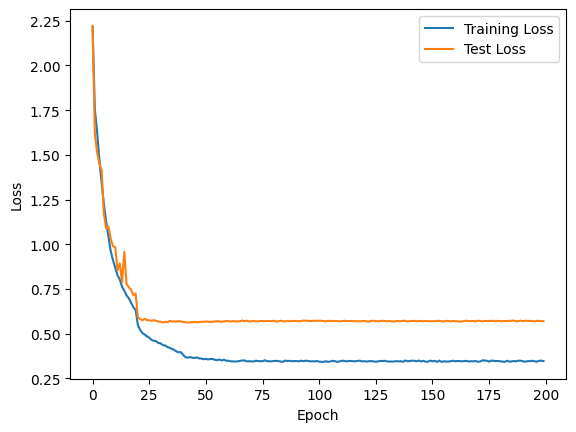

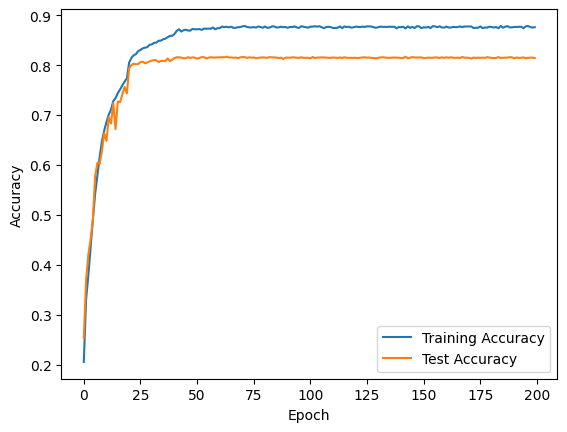

In [22]:
import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, StepLR

#lr_scheduler = ExponentialLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
# Initialize empty lists to store loss and accuracy values
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    # Use tqdm to track the progress of train_loader
    with tqdm.tqdm(train_loader, unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            images = images.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar description
            t.set_description(f"Epoch {epoch+1}")
            t.set_postfix(loss=train_loss / (i + 1), accuracy=correct / total)

    # Calculate average loss and accuracy for training set
    train_loss /= len(train_loader)
    train_accuracy = correct / total

    # Append loss and accuracy to respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    # Use tqdm to track the progress of test_loader
    with tqdm.tqdm(test_loader, unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            with torch.no_grad():
                images = images.cuda()
                labels = labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update the progress bar description
                t.set_description(f"Epoch {epoch+1}")
                t.set_postfix(loss=test_loss / (i + 1), accuracy=correct / total)

    # Calculate average loss and accuracy for test set
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Append loss and accuracy to respective lists
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Update the scheduler
    lr_scheduler.step()

    current_lr = lr_scheduler.get_last_lr()[0]  # Get the current learning rate

    print('Epoch: {}, learning rate: {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
          .format(epoch + 1, current_lr, train_loss, train_accuracy, test_loss, test_accuracy))

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms


#Threshold Selection

model.to(device)
model.eval()

softmax_threshold = 0.0  # Initialize the threshold

# Pass the original validation set through the model to obtain softmax probabilities
with torch.no_grad():
    softmax_probs = []
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        softmax_probs.extend(torch.softmax(outputs, dim=1).max(dim=1).values.tolist())

# Sort the softmax probabilities and select the threshold
sorted_softmax_probs = sorted(softmax_probs, reverse=True)
threshold_index = int(0.95 * len(sorted_softmax_probs))
softmax_threshold = sorted_softmax_probs[threshold_index]


In [24]:
softmax_threshold



0.4942605495452881

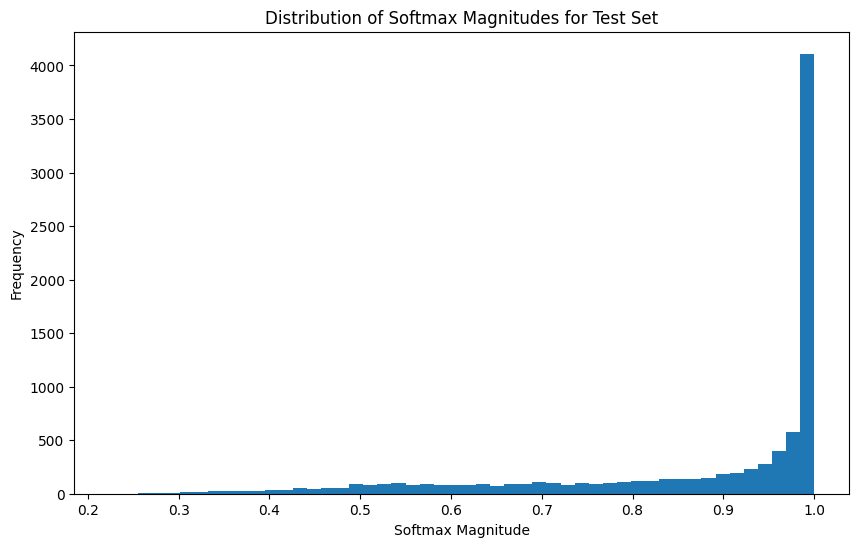

In [25]:
import numpy as np
import matplotlib.pyplot as plt

softmax_magnitudes = []

# Iterate over the test loader and calculate the softmax magnitude for each sample
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        softmax_probs = torch.softmax(outputs, dim=1)
        softmax_magnitudes.extend(torch.max(softmax_probs, dim=1).values.tolist())

# Convert the softmax magnitudes to a numpy array
softmax_magnitudes = np.array(softmax_magnitudes)

# Plot the distribution of softmax magnitudes
plt.figure(figsize=(10, 6))
plt.hist(softmax_magnitudes, bins=50)
plt.xlabel('Softmax Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Magnitudes for Test Set')
plt.show()

In [26]:
cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
frog_indices = [i for i, label in enumerate(cifar_dataset.targets) if label == 3]  # 3 represents the cat class
frog_dataset = torch.utils.data.Subset(cifar_dataset, frog_indices)

frog_dataloader_test = torch.utils.data.DataLoader(frog_dataset, batch_size=64, shuffle=False)

# Step 2: OOD Detection
ood_samples = 0
total_samples = 0

# Pass the OOD validation set (frog class) through the model and classify samples
with torch.no_grad():
    for images, _ in frog_dataloader_test:
        images = images.to(device)
        outputs = model(images)
        softmax_probs = torch.softmax(outputs, dim=1)
        max_softmax_probs, _ = softmax_probs.max(dim=1)

        ood_samples += (max_softmax_probs < softmax_threshold).sum().item()
        total_samples += len(max_softmax_probs)

ood_detection_percentage = (ood_samples / total_samples) * 100
print(f"Percentage of frog samples classified as out-of-distribution: {ood_detection_percentage}%")


Files already downloaded and verified
Percentage of frog samples classified as out-of-distribution: 9.3%


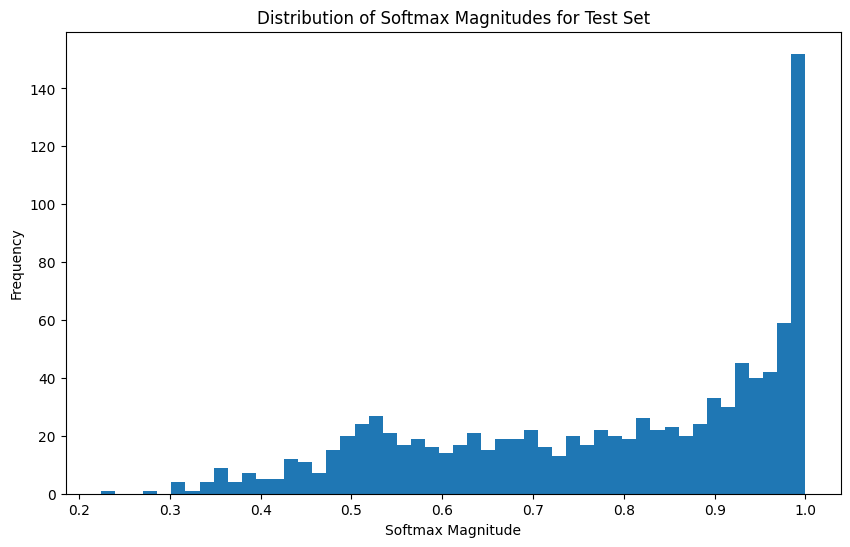

In [27]:

import numpy as np
import matplotlib.pyplot as plt

softmax_magnitudes = []

# Iterate over the test loader and calculate the softmax magnitude for each sample
with torch.no_grad():
    for images, _ in frog_dataloader_test:
        images = images.to(device)
        outputs = model(images)
        softmax_probs = torch.softmax(outputs, dim=1)
        softmax_magnitudes.extend(torch.max(softmax_probs, dim=1).values.tolist())

# Convert the softmax magnitudes to a numpy array
softmax_magnitudes = np.array(softmax_magnitudes)

# Plot the distribution of softmax magnitudes
plt.figure(figsize=(10, 6))
plt.hist(softmax_magnitudes, bins=50)
plt.xlabel('Softmax Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Magnitudes for Test Set')
plt.show()